In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

In [2]:
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

In [3]:
# samples_dict = {"Immature": "A0021_043", "0hr": "A0008_041", "1hr": "A0021_044", "4hr": "A0008_045", "4hr_replicate": "A0021_042", "6hr": "A0021_045", "8hr": "A0008_044", "8hr_replicate": "A0021_038", "11hr": "A0008_046", "12hr": "A0021_046"}
samples_dict = {"Immature": "A0021_043", "0hr": "A0008_041", "1hr": "A0021_044", "4hr": "A0021_042", "6hr": "A0021_045", "8hr": "A0008_044", "11hr": "A0008_046", "12hr": "A0021_046"}

In [5]:
s_genes = list(pd.read_csv("./../../../../MouseInfection/s.genes.txt")["x"])
g2m_genes = list(pd.read_csv("./../../../../MouseInfection/g2m.genes.txt")["x"])
print(s_genes)
print(g2m_genes)

['Mcm4', 'Exo1', 'Slbp', 'Gmnn', 'Cdc45', 'Msh2', 'Mcm6', 'Rrm2', 'Pold3', 'Blm', 'Ubr7', 'Mcm5', 'Clspn', 'Hells', 'Nasp', 'Rpa2', 'Rad51ap1', 'Tyms', 'Rrm1', 'Rfc2', 'Prim1', 'Brip1', 'Usp1', 'Ung', 'Pola1', 'Mcm2', 'Fen1', 'Tipin', 'Pcna', 'Cdca7', 'Uhrf1', 'Casp8ap2', 'Cdc6', 'Dscc1', 'Wdr76', 'E2f8', 'Dtl', 'Ccne2', 'Atad2', 'Gins2', 'Chaf1b', 'Pcna-ps2']
['Nuf2', 'Psrc1', 'Ncapd2', 'Ccnb2', 'Smc4', 'Lbr', 'Tacc3', 'Cenpa', 'Kif23', 'Cdca2', 'Anp32e', 'G2e3', 'Cdca3', 'Anln', 'Cenpe', 'Gas2l3', 'Tubb4b', 'Cenpf', 'Dlgap5', 'Hjurp', 'Cks1brt', 'Gtse1', 'Bub1', 'Birc5', 'Ube2c', 'Rangap1', 'Hmmr', 'Ect2', 'Tpx2', 'Ckap5', 'Cbx5', 'Nek2', 'Ttk', 'Cdca8', 'Nusap1', 'Ctcf', 'Cdc20', 'Cks2', 'Mki67', 'Tmpo', 'Ckap2l', 'Aurkb', 'Kif2c', 'Cdk1', 'Kif20b', 'Top2a', 'Aurka', 'Ckap2', 'Hmgb2', 'Cdc25c', 'Ndc80', 'Kif11']


In [16]:
# Oocyte only
oocytes = adata_ovary_combined.raw.to_adata()[adata_ovary_combined.obs["Level0_max_pred_celltype"] == "Level0_Oocyte",]
oocytes = oocytes[oocytes.obs["Level0_max_pred"] > 0.5]
oocytes.shape

(1728, 31053)

In [17]:
oocyte_dict = dict()
for sample in samples_dict.keys():
        oocyte_dict[sample] = oocytes[oocytes.obs["Sample"] == sample]
        oocyte_dict

In [18]:
import scipy.spatial as scisp
for sample in samples_dict.keys():
    # Calculate euclidean distances
    oocyte_dict[sample].obsm["spatial_distances"] = scisp.distance.squareform(scisp.distance.pdist(oocyte_dict[sample].obsm['spatial']))
    oocyte_dict[sample].obs["spatial_neighbors_100_true"] = np.sum(oocyte_dict[sample].obsm["spatial_distances"] < 100, axis=0)

In [19]:
for sample in samples_dict.keys():
#     sc.pl.spatial(oocyte_dict[sample][oocyte_dict[sample].obs["spatial_neighbors_100_true"] >= 5,], color=["leiden_1.5", "spatial_neighbors_100_true"], spot_size=30, wspace=0.25, title=sample)
    oocyte_dict[sample] = oocyte_dict[sample][oocyte_dict[sample].obs["spatial_neighbors_100_true"] >= 5,]

In [20]:
oocytes = oocyte_dict[list(samples_dict.keys())[0]].concatenate([oocyte_dict[x] for x in list(samples_dict.keys())[1:]], index_unique = None)
del oocyte_dict
oocytes.obs = oocytes.obs.drop(columns=["batch"])

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [21]:
# count the number of occurrences of each category
oocytes.obs["oocyte_clusters"] = oocytes.obs["FollicleNumber"]
oocytes.obs["oocyte_clusters"] = oocytes.obs["oocyte_clusters"].astype(str)
oocytes.obs.loc[oocytes.obs["Level0_max_pred_celltype"] != "Level0_Oocyte", "oocyte_clusters"] = np.NAN

# Chnage oocyte labels to categories again
oocytes.obs["oocyte_clusters"] = oocytes.obs["oocyte_clusters"].astype("category")

In [22]:
oocytes.obs.Follicle_type.value_counts()

Preantral    569
Antral       520
Atretic      216
Lytic         14
Name: Follicle_type, dtype: int64

In [23]:
oocytes.obs["Follicle_type"] = adata_ovary_combined[oocytes.obs_names].obs["Follicle_type"]

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python

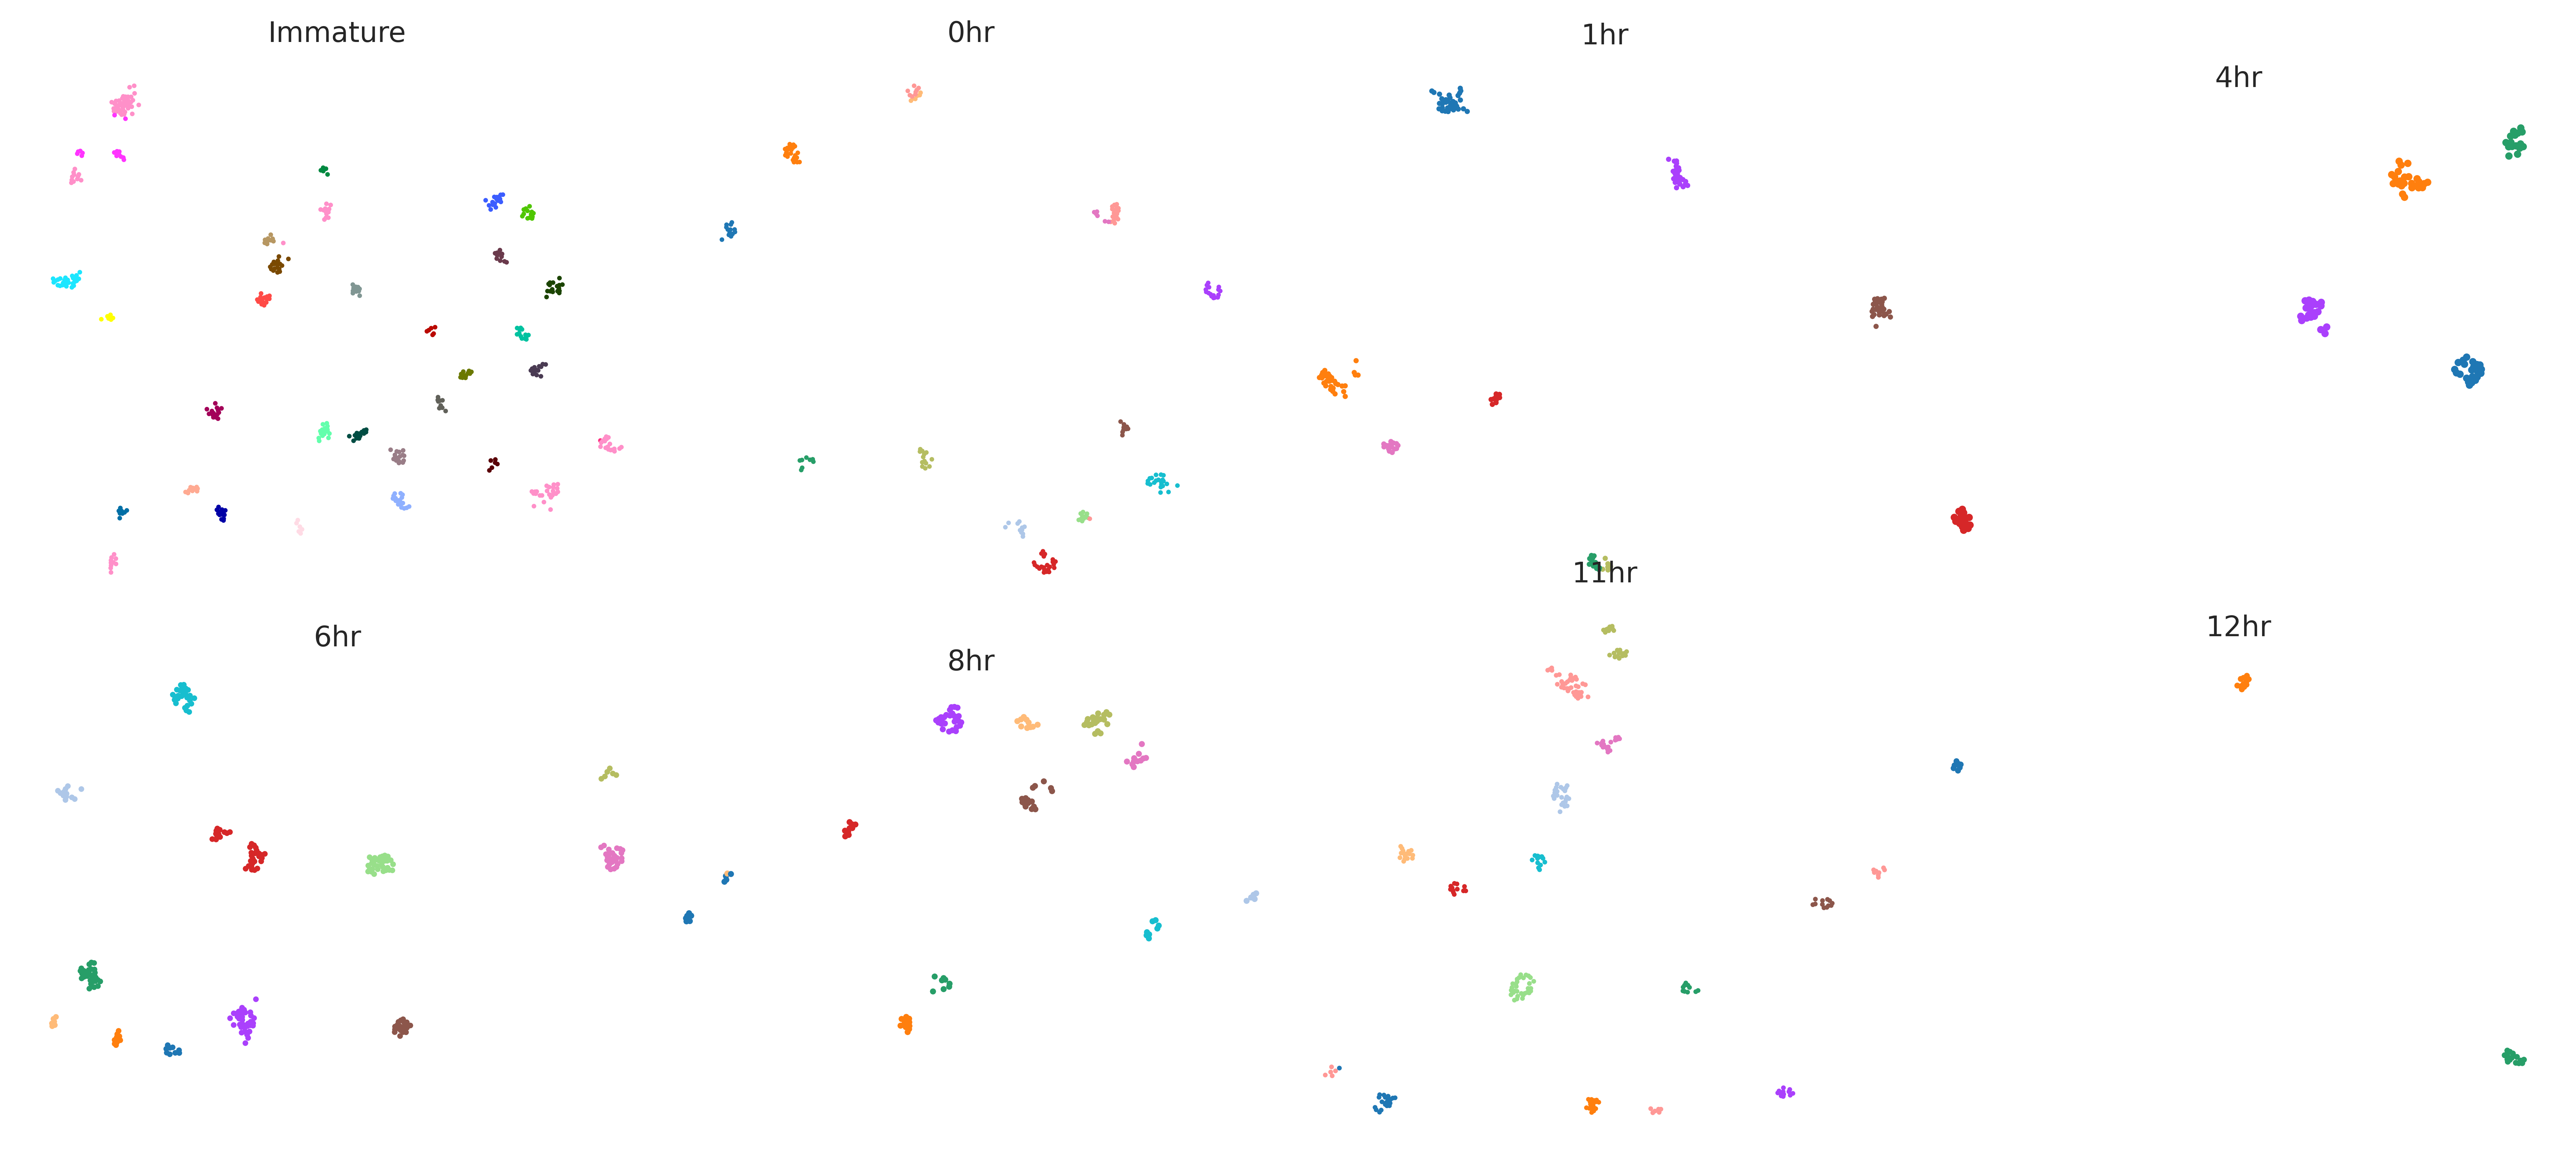

In [25]:
sc.settings.set_figure_params(dpi=300, dpi_save= 300, fontsize=10, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = True, transparent=True, format="pdf")
grouping_var = "oocyte_clusters"
fig, axs = plt.subplots(2,4, figsize = (16,7))
for i, sample in enumerate(samples_dict.keys()):
    subset = oocytes[oocytes.obs["Sample"] == sample]
#     subset.obs[grouping_var] = subset.obs[grouping_var].cat.set_categories(adata_ovary_combined.obs[grouping_var].cat.categories)
#     print(subset.obs[grouping_var].cat.categories)
    if i == 3:
        sc.pl.spatial(subset, color = [grouping_var], wspace= 0.0, hspace = 0.0, spot_size = 30, frameon=False, title=sample, show=False, ax=axs[int(i/4), int(i%4)], na_color="lightgray", na_in_legend=False)
        handles, labels = axs[int(i/4), int(i%4)].get_legend_handles_labels()
        axs[int(i/4), int(i%4)].get_legend().remove()
    else: 
        sc.pl.spatial(subset, color = [grouping_var], wspace= 0.0, hspace = 0.0, spot_size = 30, frameon=False, title=sample, show=False, legend_loc="none", ax=axs[int(i/4), int(i%4)], na_color="lightgray", na_in_legend=False)  
# fig.legend(handles, labels, ncol = 3, loc='lower center', bbox_to_anchor = (0.57,0.05), title = "Predicted oocyte beads")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig("./figures/spatial_maps_granulosa.pdf")

In [32]:
oocytes.write_h5ad("./../../pyobjs_github/oocytes_combined.h5ad")

In [33]:
oocytes = sc.read_h5ad("./../../pyobjs_github/oocytes_combined.h5ad")
oocytes.shape

(1607, 31053)

In [27]:
# Load your anndata object
adata = sc.read_h5ad("./../../pyobjs_github/adata_ovary_combined_raw_counts_filtered.h5ad")
adata = adata[oocytes.obs_names]
adata.obs = oocytes.obs
print(adata.shape)

# Set the categorical metadata variable to use for pseudobulk matrix construction
metadata_variable = 'FollicleNumber'

# Get the unique values of the metadata variable
metadata_values = adata.obs[metadata_variable].astype(str).unique()

# Initialize an empty dictionary to store the pseudobulk matrices
pseudobulk_dfs = list()

# Loop over each metadata value and create a pseudobulk matrix for each subset of cells
for metadata_value in metadata_values:
    if metadata_value == "nan": 
        continue
    # Subset the anndata object based on the metadata variable
    subset_indices = np.where(adata.obs[metadata_variable] == metadata_value)[0]
    subset_adata = adata[subset_indices, :]

    # Calculate mean expression for each gene across all cells in the subset
    mean_expression = np.sum(subset_adata.X, axis=0)

    # Create a dataframe with gene names as row names and mean expression values as a single column
    pseudobulk_dfs.append(pd.DataFrame(data=mean_expression.T, index=adata.var_names, columns=[metadata_value]))
    
# Create a merged df with pseudobulk expression
pseudobulk_df = pseudobulk_dfs[0].join(pseudobulk_dfs[1:])
print(pseudobulk_df.shape)
del pseudobulk_dfs

(1607, 31053)
(31053, 88)


In [28]:
print(np.sum(pseudobulk_df).sum())

2243877.0


In [30]:
# print(pseudobulk_df.shape)
pseudobulk_df.to_csv("./../../mouse_ovulation/csvs/oocyte_pseudobulk_thresh0.5.csv")

In [35]:
oocytes = sc.read_h5ad("./../../pyobjs_github/oocytes_combined.h5ad")
oocytes.shape

(1607, 31053)

In [36]:
pseudobulk_df = pd.read_csv("./../../mouse_ovulation/csvs/oocyte_pseudobulk_thresh0.5.csv", index_col=0)
pseudobulk_df.shape

(31053, 88)

In [332]:
# print(np.sum(pd.read_csv("./../pyobjs/oocyte_pseudobulk_thresh0.9.csv", index_col=0)).sum())
# print(np.sum(pd.read_csv("./../pyobjs/oocyte_pseudobulk_thresh0.5.csv", index_col=0)).sum())
# print(np.sum(pd.read_csv("./../pyobjs/oocyte_pseudobulk.csv", index_col=0)).sum())

In [38]:
mode_df = pd.read_csv("./../../mouse_ovulation/csvs/follicle_metadata.csv")
print(mode_df.shape)
mode_df.head()

(335, 5)


,Unnamed: 0,FollicleNumber,Follicle_type,Sample,size
0,0,Follicle0,Atretic,Immature,49
1,1,Follicle1,Antral,Immature,226
2,2,Follicle2,Preantral,Immature,16
3,3,Follicle3,Atretic,Immature,67
4,4,Follicle4,Preantral,Immature,16


In [39]:
mode_df["Follicle_type"].value_counts()

Antral       116
Preantral     97
Atretic       92
Lytic         30
Name: Follicle_type, dtype: int64

In [66]:
mode_df = oocytes.obs.groupby('FollicleNumber')[['Follicle_type', "Sample"]].apply(lambda x: x.mode()).reset_index()
mode_df["size"] = oocytes.obs.groupby('FollicleNumber').size().values
mode_df["total_counts"] = oocytes.obs.groupby('FollicleNumber')['total_counts'].apply(lambda x: x.sum()).reset_index()["total_counts"]
mode_df = mode_df.drop('level_1', axis=1)
mode_df = mode_df.drop_duplicates(subset='FollicleNumber', keep='first')
mode_df = mode_df.set_index(mode_df["FollicleNumber"])
print(mode_df.shape)

(88, 5)


In [67]:
mode_df = mode_df[~pd.isna(mode_df.Follicle_type)]

In [68]:
freq_table = mode_df.groupby(['Sample', 'Follicle_type']).size().reset_index(name='count')
# freq_table = freq_table[~freq_table["Follicle_type"].isin(["Transitioning"])]
freq_table['total_count'] = freq_table.groupby(["Sample"])['count'].transform('sum')
freq_table['proportion'] = freq_table['count'] / freq_table['total_count']
freq_table["Sample"] = freq_table["Sample"].astype("category")
freq_table["Sample"] = freq_table["Sample"].cat.reorder_categories(["Immature", "0hr", "1hr", "4hr", "6hr", "8hr", "11hr", "12hr"])
freq_table["Sample"] = freq_table["Sample"].cat.rename_categories({"Immature": "Untreated", "0hr": "0h", "1hr": "1h", "4hr": "4h", "6hr": "6h", "8hr": "8h", "11hr": "11h", "12hr": "12h"})
freq_table["Follicle_type"] = freq_table["Follicle_type"].astype("category")
# freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.remove_categories(["Transitioning"])
freq_table["Follicle_type"] = freq_table["Follicle_type"].cat.reorder_categories(["Preantral", "Antral", "Atretic", "Lytic"])

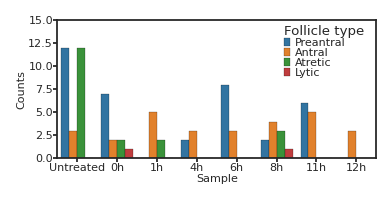

In [70]:
sc.settings.set_figure_params(dpi=80, fontsize=5, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (2.4,1.2))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.barplot(freq_table, y = "count", x = "Sample", hue="Follicle_type",  dodge=True, palette="tab10", ax=ax, 
           linewidth=0.1, edgecolor="black")
plt.legend(ncol=1, prop={'size': 5}, handletextpad=0.5, markerscale = 0.6, title = "Follicle type",
           labelspacing = 0.0, frameon = False,  title_fontsize = 6, alignment = "left", 
           borderpad = 0.1, borderaxespad = 0.1, bbox_to_anchor = (0.97, 0.98))
plt.rcParams['legend.title_fontsize'] = 9
ax.set_ylim(0,15)
ax.set_ylabel("Counts", labelpad = 1.0)
ax.set_xlabel("Sample", labelpad = 0.5)
plt.tight_layout()
plt.savefig("./figures/oocyte_follicle_type_stats.pdf")

In [42]:
import anndata as ad
pseudobulk_df_filtered = pseudobulk_df[mode_df[mode_df["size"] >= 0].index]
oocytes_bulk = ad.AnnData(X=pseudobulk_df_filtered.T)
oocytes_bulk.obs = mode_df.loc[oocytes_bulk.obs_names,]

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:782: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['Follicle1', 'Follicle2', 'Follicle4', 'Follicle5', 'Follicle12']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [43]:
oocytes_bulk.obs["Follicle_type"].value_counts()

Preantral    37
Antral       28
Atretic      19
Lytic         2
Name: Follicle_type, dtype: int64

In [44]:
oocytes_bulk.obs["Sample"] = oocytes_bulk.obs["Sample"].cat.reorder_categories(list(samples_dict.keys()))

In [50]:
oocytes_bulk[oocytes_bulk.obs["Sample"] == "4hr"].obs["Sample"]

Follicle188    4hr
Follicle196    4hr
Follicle197    4hr
Follicle198    4hr
Follicle200    4hr
Name: Sample, dtype: category
Categories (1, object): ['4hr']

In [51]:
oocytes_bulk.write_h5ad("./../../pyobjs_github/oocytes_bulk_rawcounts.h5ad")

In [52]:
correlation_df = pd.read_csv("./../../../pyobjs/correlations_magic_full_oocyte_pred.csv", index_col=0)

In [53]:
oocyte_genes = correlation_df[correlation_df["correlation"]>0.5]["gene"].values
print(len(oocyte_genes))

5373


In [463]:
correlation_df.loc["Tet3",]

gene               Tet3
correlation    0.871773
means          0.225243
dispersions    2.700251
Name: Tet3, dtype: object

In [58]:
# oocytes_bulk = sc.read_h5ad("./../../pyobjs_github/oocytes_bulk_rawcounts.h5ad")
# oocytes_bulk

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 86 × 31053
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size', 'total_counts'

In [59]:
oocytes_bulk = oocytes_bulk[:,oocyte_genes]
sc.pp.filter_genes(oocytes_bulk, min_cells=1)
oocytes_bulk.obs["total_counts"] = oocytes_bulk.to_df().sum(axis=1)
oocytes_bulk.obs["ngenes_counts"] = np.sum(oocytes_bulk.to_df() != 0.0, axis=1)
oocytes_bulk

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 86 × 4841
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size', 'total_counts', 'ngenes_counts'
    var: 'n_cells'

In [60]:
oocytes_bulk = oocytes_bulk[oocytes_bulk.obs["size"] >= 5,]
# oocytes_bulk = oocytes_bulk[oocytes_bulk.obs["total_counts"] >= 1000,]
oocytes_bulk.shape

(85, 4841)

In [61]:
oocytes_bulk = oocytes_bulk[~oocytes_bulk.obs["Follicle_type"].isin(["Lytic"])]

In [71]:
oocytes_bulk.obs["Sample"] = oocytes_bulk.obs["Sample"].cat.rename_categories({"Immature": "Untreated", "0hr": "0h", "1hr": "1h", "4hr": "4h", "6hr": "6h", "8hr": "8h", "11hr": "11h", "12hr": "12h"})


/tmp/ipykernel_1757611/2458969856.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  oocytes_bulk.obs["Sample"] = oocytes_bulk.obs["Sample"].cat.rename_categories({"Immature": "Untreated", "0hr": "0h", "1hr": "1h", "4hr": "4h", "6hr": "6h", "8hr": "8h", "11hr": "11h", "12hr": "12h"})


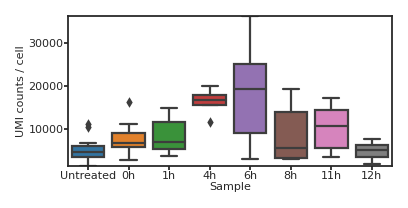

In [78]:
sc.settings.set_figure_params(dpi=80, fontsize=5, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (2.5,1.25))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.boxplot(oocytes_bulk.obs, y = "total_counts", x = "Sample", dodge=True, palette="tab10", linewidth=1.0, fliersize=2.0, ax=ax)
plt.rcParams['legend.title_fontsize'] = 9
# ax.set_ylim(0,5000)
# ax.set_yscale("log")
ax.set_ylabel("UMI counts / cell", labelpad = 1.0)
ax.set_xlabel("Sample", labelpad = 0.5)
plt.tight_layout()
plt.savefig("./figures/oocytes_total_counts.pdf")

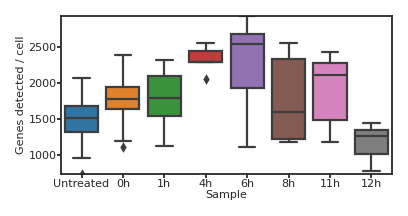

In [74]:
sc.settings.set_figure_params(dpi=80, fontsize=5, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (2.5,1.3))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.boxplot(oocytes_bulk.obs, y = "ngenes_counts", x = "Sample", dodge=True, palette="tab10", ax=ax, linewidth=1.0, fliersize=2.0)
plt.rcParams['legend.title_fontsize'] = 9
# ax.set_ylim(0,5000)
# ax.set_yscale("log")
ax.set_ylabel("Genes detected / cell", labelpad = 1.0)
ax.set_xlabel("Sample", labelpad = 0.5)
plt.tight_layout()
plt.savefig("./figures/oocytes_ngenes_counts.pdf")

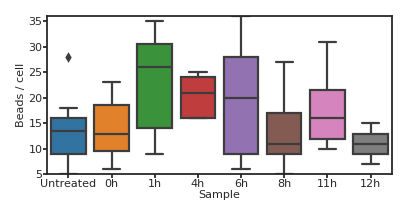

In [75]:
sc.settings.set_figure_params(dpi=80, fontsize=5, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (2.5,1.3))
plt.margins(x=0, y=0)
ax.tick_params(axis='both', which='major', pad=0, size = 2)
sns.boxplot(oocytes_bulk.obs, y = "size", x = "Sample", dodge=True, palette="tab10", linewidth=1.0, fliersize=2.0, ax=ax)
plt.rcParams['legend.title_fontsize'] = 9
# ax.set_ylim(0,5000)
# ax.set_yscale("log")
ax.set_ylabel("Beads / cell", labelpad = 1.0)
ax.set_xlabel("Sample", labelpad = 0.5)
plt.tight_layout()
plt.savefig("./figures/oocytes_size.pdf")

In [77]:
oocytes_bulk.obs["size"].mean()

15.710843373493976

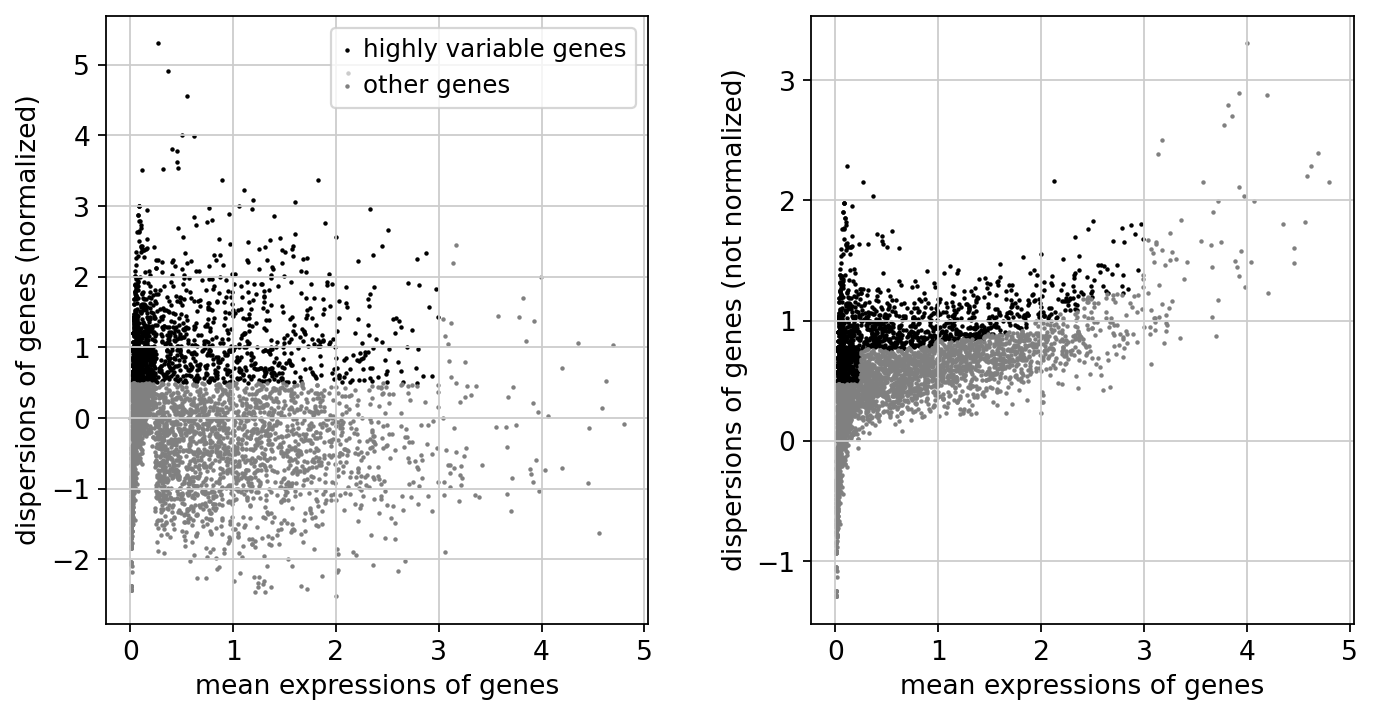

1421


In [470]:
sc.pp.normalize_total(oocytes_bulk, target_sum = 1e4, inplace=True)
sc.pp.log1p(oocytes_bulk)
sc.tl.score_genes_cell_cycle(oocytes_bulk, s_genes=s_genes, g2m_genes=g2m_genes)
sc.pp.highly_variable_genes(oocytes_bulk)
sc.pl.highly_variable_genes(oocytes_bulk)
print(np.sum(oocytes_bulk.var.highly_variable))

(83, 1421)


/home/mm2937/.local/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


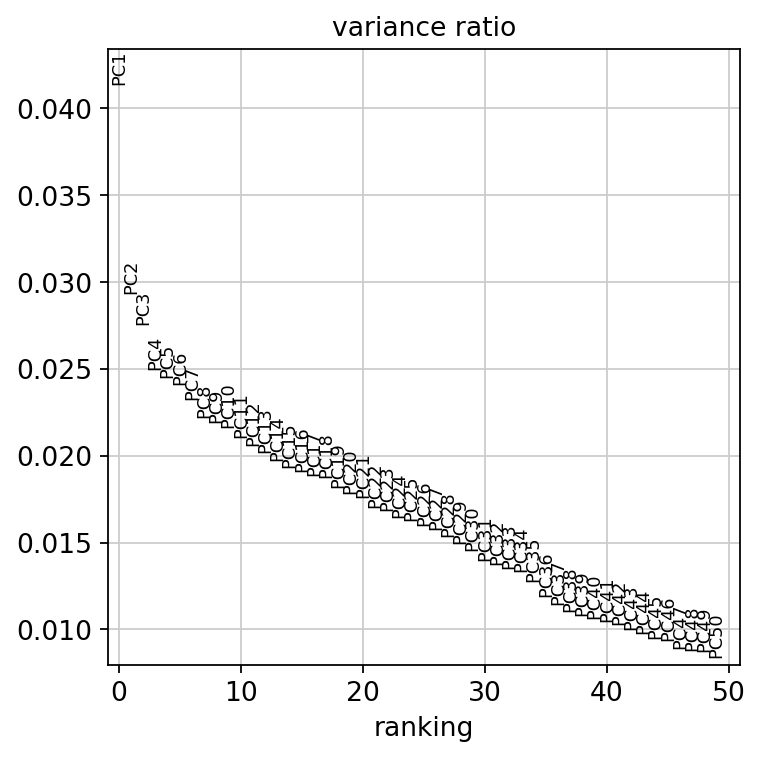

In [471]:
oocytes_bulk.raw = oocytes_bulk
oocytes_bulk = oocytes_bulk[:, oocytes_bulk.var.highly_variable]
print(oocytes_bulk.shape)
# sc.pp.regress_out(oocytes_bulk)
sc.pp.scale(oocytes_bulk, max_value=10)
sc.pp.pca(oocytes_bulk, random_state= 0)
sc.pl.pca_variance_ratio(oocytes_bulk, n_pcs = 50)

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


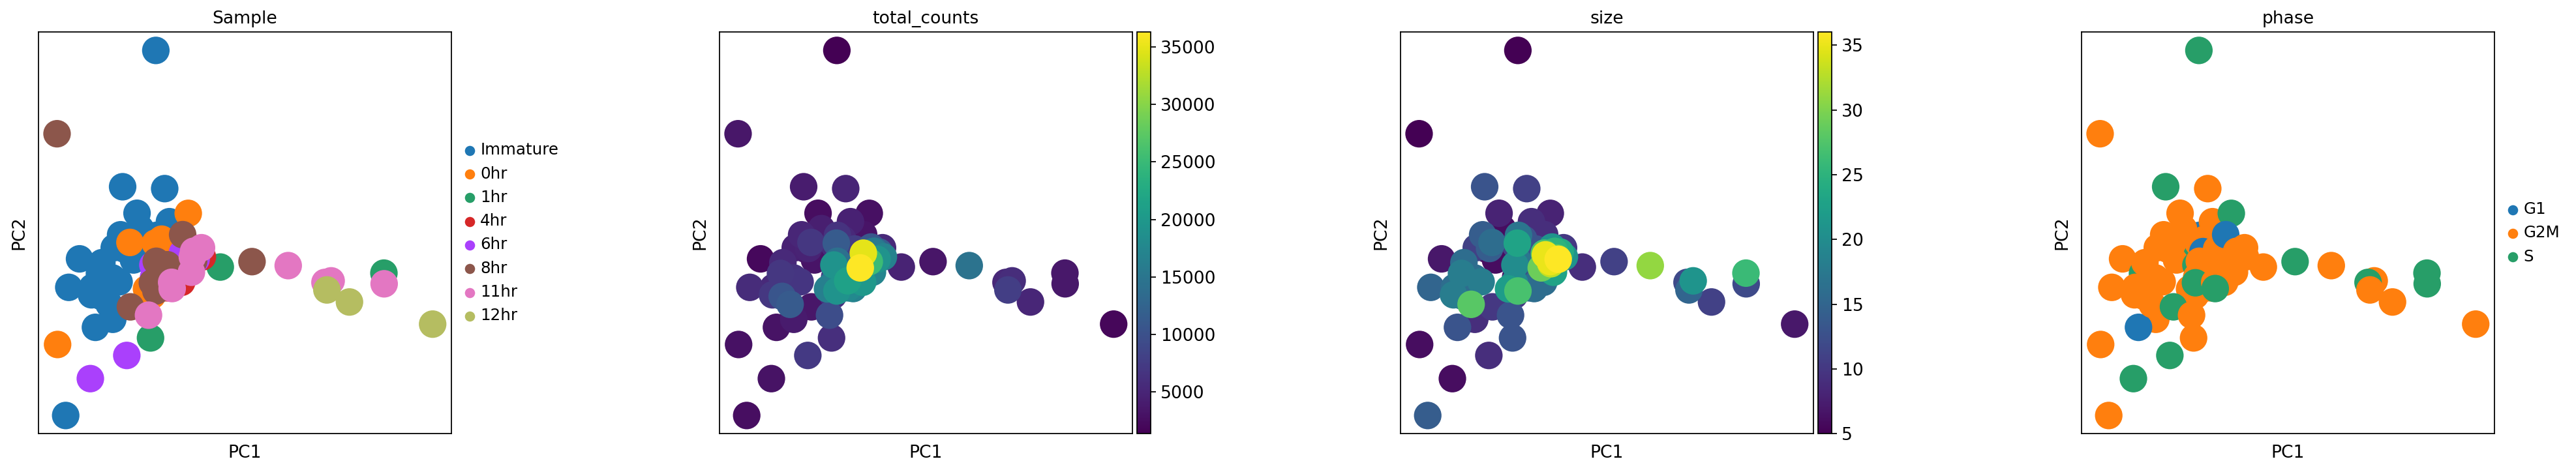

In [472]:
sc.pl.pca(oocytes_bulk, color=["Sample", "total_counts", "size", "phase"], wspace=0.5)

In [473]:
correlation_df.loc["H1foo",]

gene              H1foo
correlation     0.89787
means          0.672873
dispersions    3.516821
Name: H1foo, dtype: object

In [474]:
sc.pp.neighbors(oocytes_bulk, n_pcs=50)
sc.tl.umap(oocytes_bulk)

In [475]:
sc.tl.leiden(oocytes_bulk, key_added="oocyte_leiden_0.5", resolution = 0.5)
sc.tl.leiden(oocytes_bulk, key_added="oocyte_leiden_0.7", resolution = 0.7)
sc.tl.leiden(oocytes_bulk, key_added="oocyte_leiden_0.8", resolution = 0.8)

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


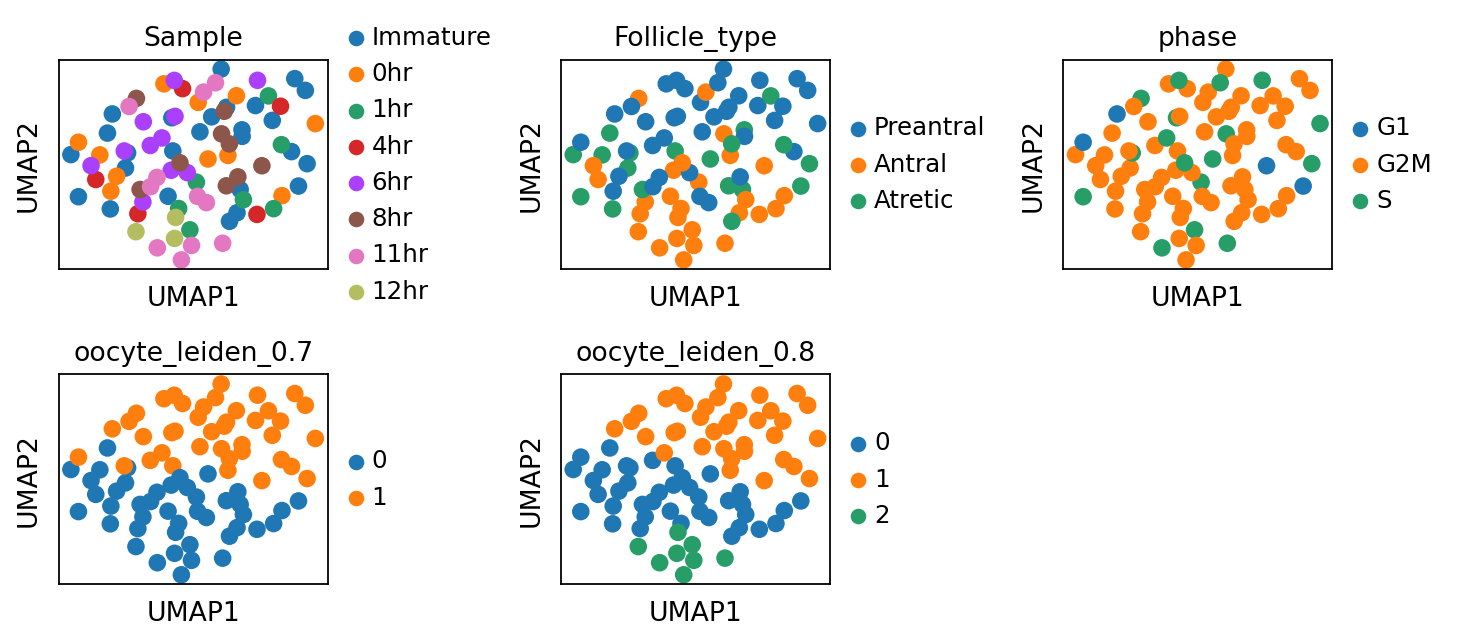

In [476]:
sc.settings.set_figure_params(dpi=80, fontsize=12, facecolor='white', frameon=True, figsize=(2, 2))
sc.pl.umap(oocytes_bulk, color=["Sample", "Follicle_type", "phase", "oocyte_leiden_0.7", "oocyte_leiden_0.8"], wspace=0.7, hspace=0.5, size=250, ncols=3)

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


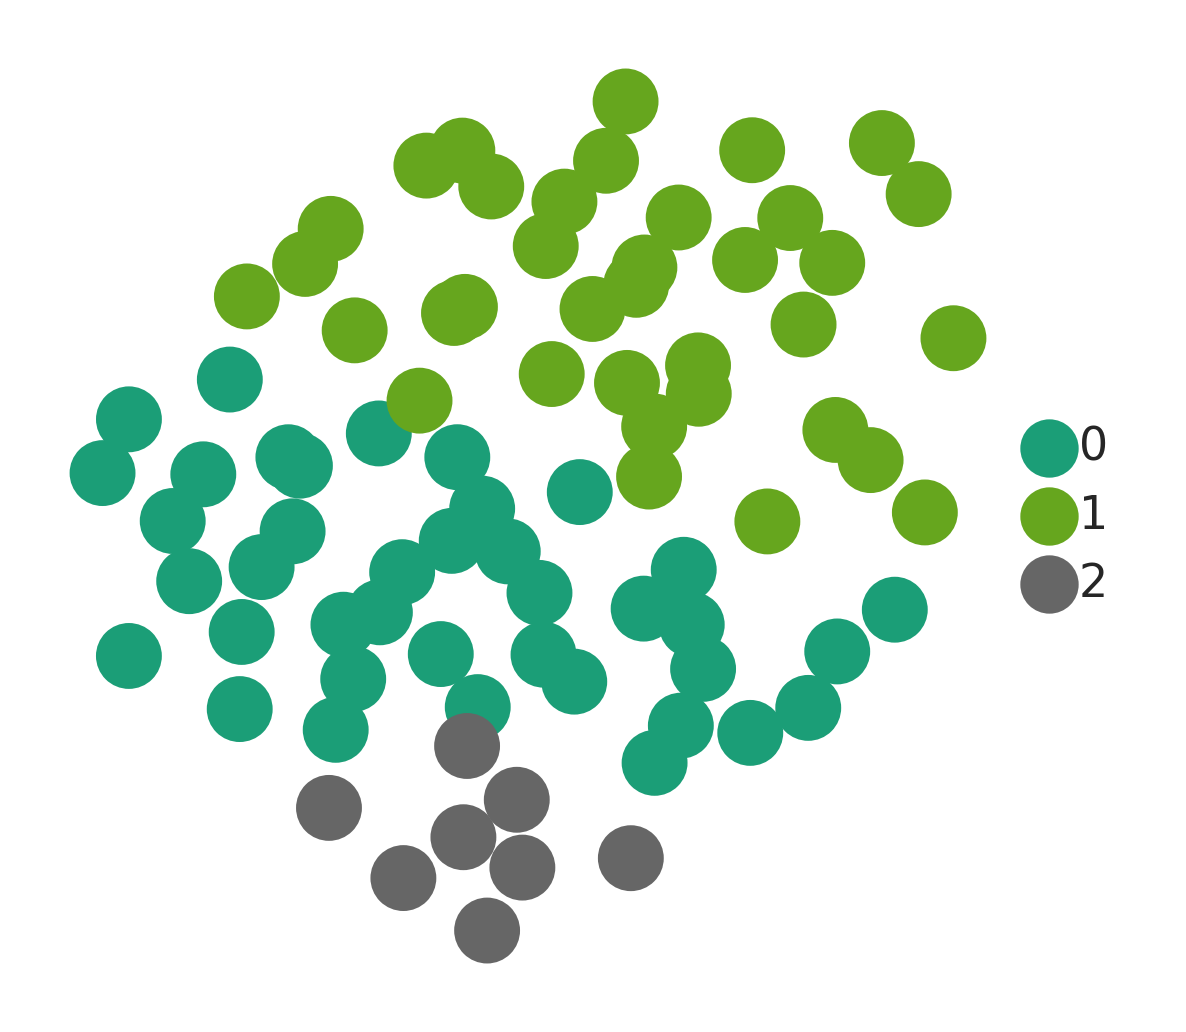

In [553]:
sc.settings.set_figure_params(dpi=300, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2))
sc.pl.umap(oocytes_bulk, size = 250.0, color = ["oocyte_leiden_0.8"], ncols=3, palette="Dark2", wspace=0.5, hspace = 0.5, title = "", save = "oocytes_clusters.pdf")

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


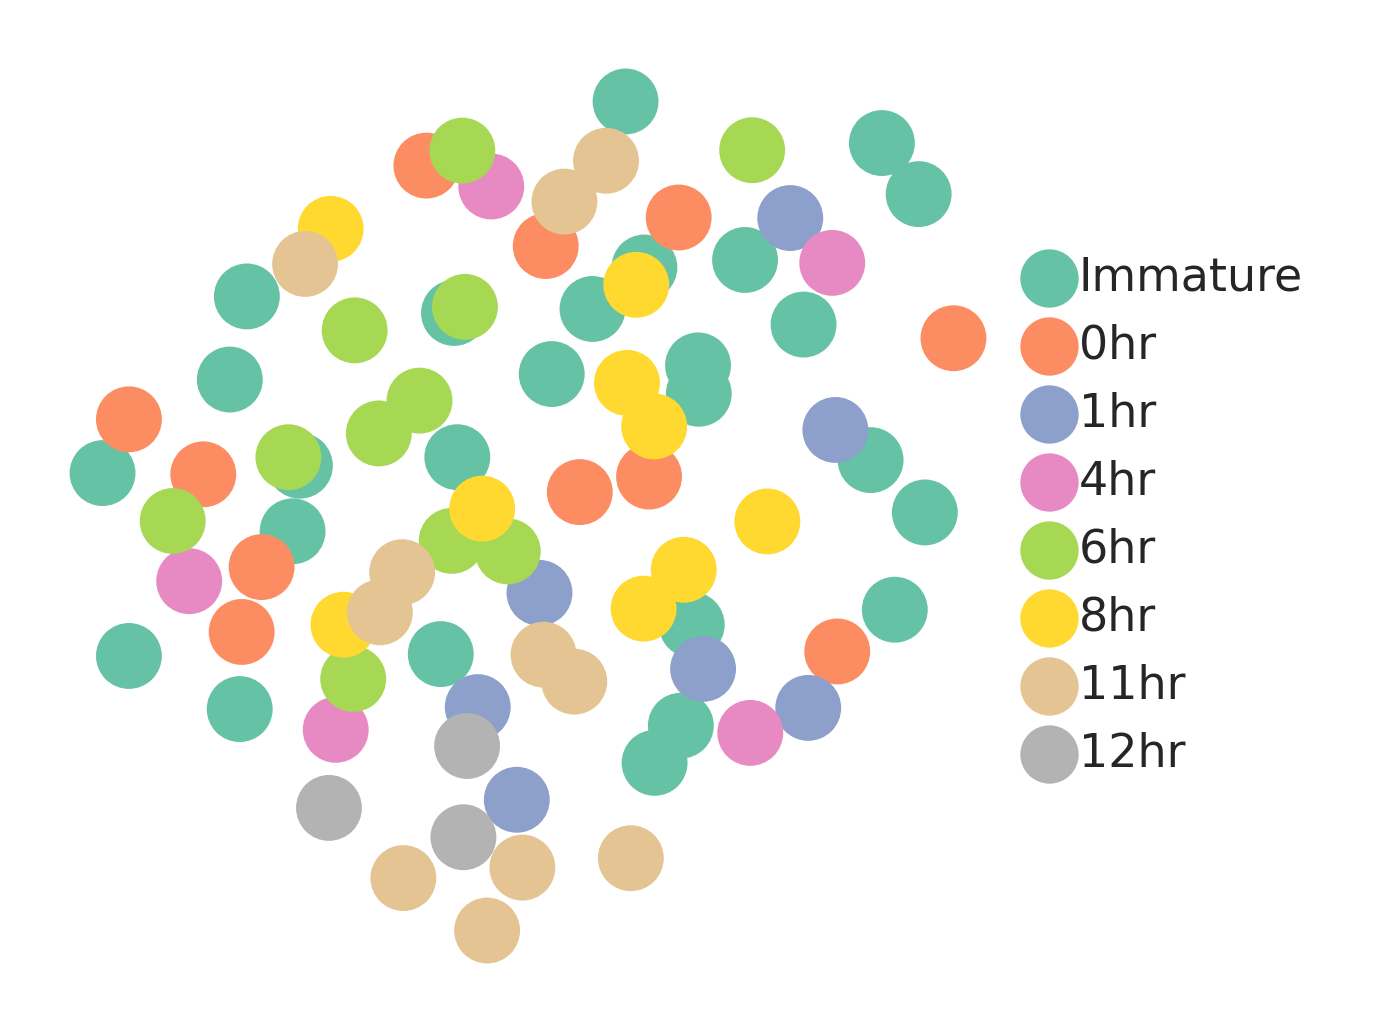

In [546]:
sc.settings.set_figure_params(dpi=300, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2))
sc.pl.umap(oocytes_bulk, size = 250.0, color = ["Sample"], ncols=3, palette="Set2", wspace=0.5, hspace = 0.5, title = "", save = "oocytes_samples.pdf")

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


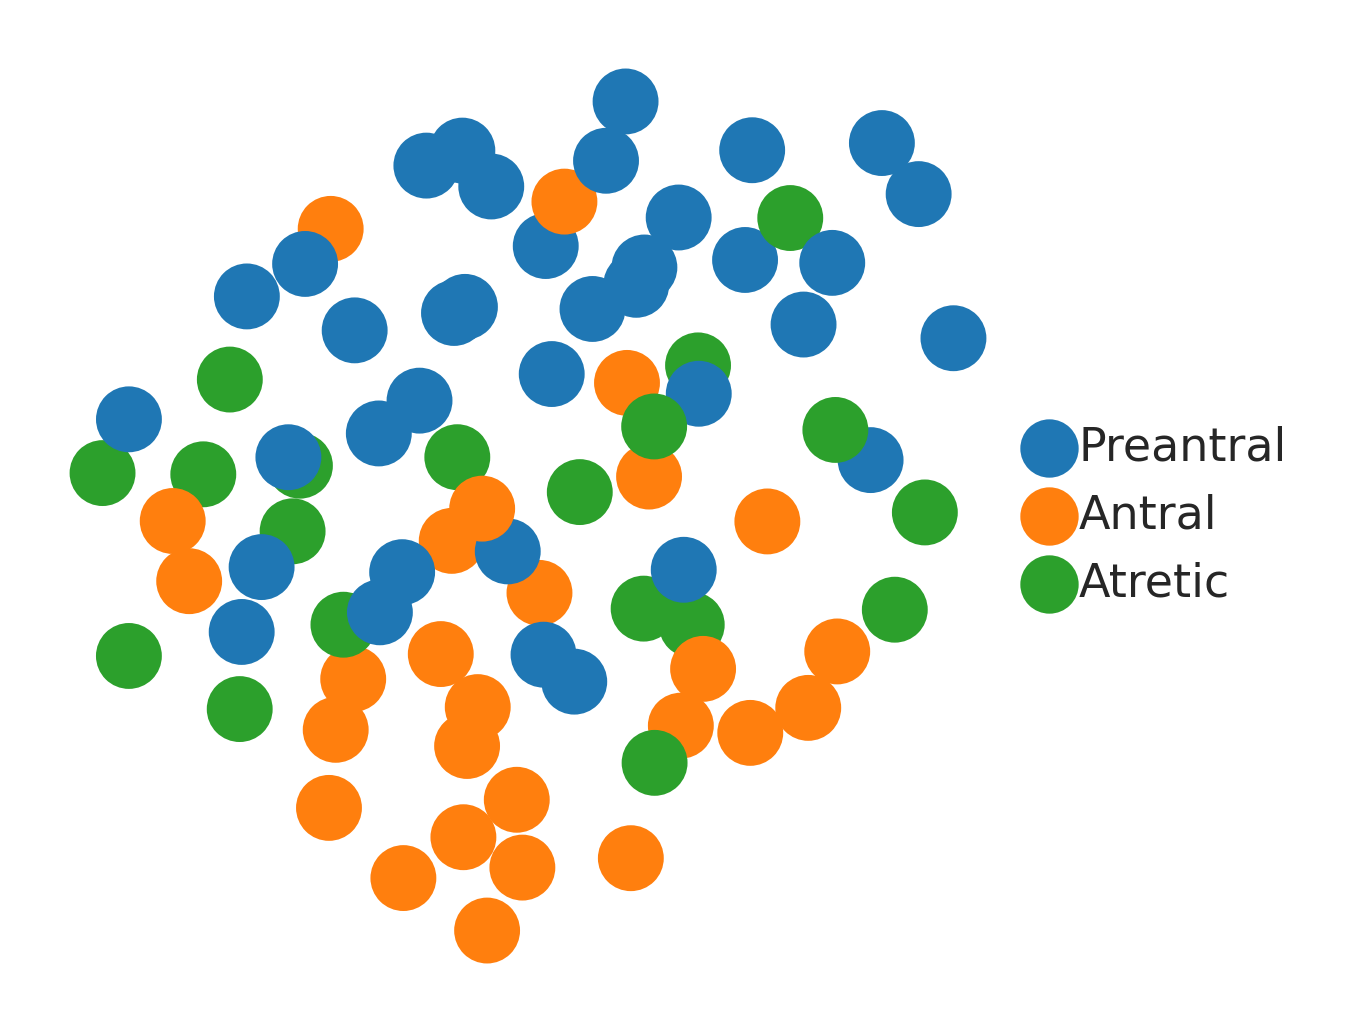

In [552]:
from pylab import *
cmap = cm.get_cmap('tab10')
palette_custom = [matplotlib.colors.rgb2hex(cmap(i)) for i in range(cmap.N)]
cmap

sc.settings.set_figure_params(dpi=300, dpi_save=300, facecolor='white', fontsize=6, frameon=False, figsize=(2, 2))
sc.pl.umap(oocytes_bulk, size = 250.0, color = ["Follicle_type"], ncols=3, palette=palette_custom[0:3], wspace=0.5, hspace = 0.5, title = "", save = "oocytes_follicle_type.pdf")

In [480]:
sc.tl.rank_genes_groups(oocytes_bulk, groupby="Follicle_type", use_raw=True, key_added='rank_genes_groups_oocytes_Follicle_type', pts=True, method="wilcoxon")
# sc.tl.filter_rank_genes_groups(oocytes_bulk, key="rank_genes_groups_oocytes_Follicle_type", key_added="rank_genes_groups_oocytes_Follicle_type_filtered")

In [579]:
sc.tl.rank_genes_groups(oocytes_bulk, groupby="oocyte_leiden_0.8", use_raw=True, key_added='rank_genes_groups_oocytes_leiden_0.8', pts=True)
# sc.tl.rank_genes_groups(oocytes_bulk, groupby="oocyte_leiden_1.0", use_raw=True, key_added='rank_genes_groups_oocytes_leiden_1.0')

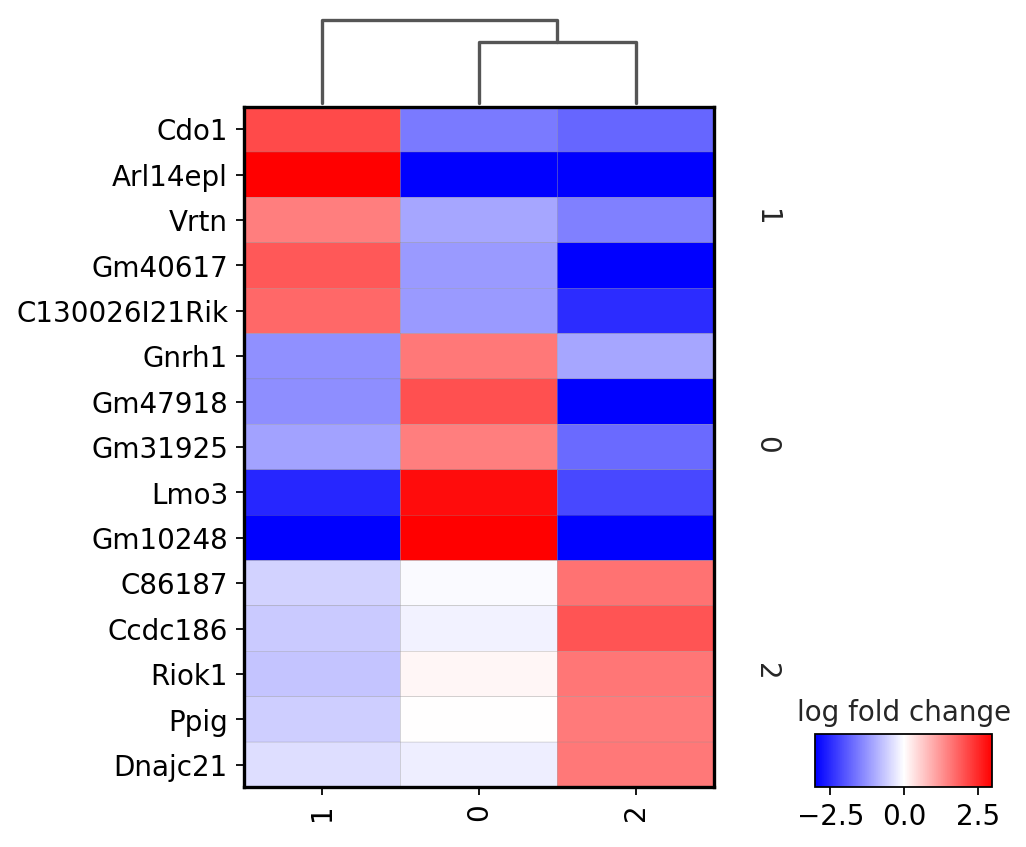

In [580]:
sc.settings.set_figure_params(dpi=80, fontsize=15, facecolor='white', frameon=True, figsize=(10, 15))
sc.pl.rank_genes_groups_matrixplot(oocytes_bulk, n_genes=5, swap_axes=True, key="rank_genes_groups_oocytes_leiden_0.8", min_logfoldchange=1.5 ,values_to_plot='logfoldchanges', vmax=3, vmin=-3, cmap='bwr', save="rank_genes_groups_oocytes_leiden_0.7", figsize = (6,6))
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(2, 2))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


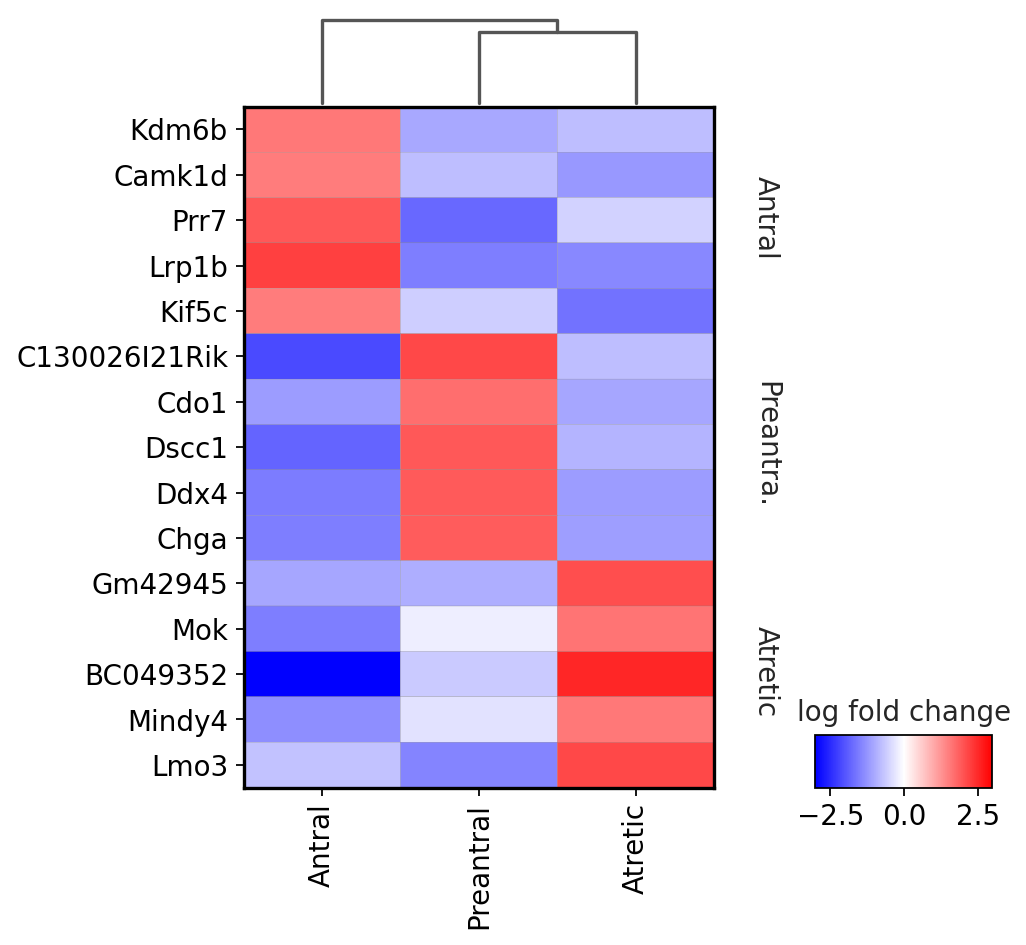

In [540]:
sc.settings.set_figure_params(dpi=80, fontsize=15, facecolor='white', frameon=True, figsize=(10, 15))
sc.pl.rank_genes_groups_matrixplot(oocytes_bulk, n_genes=5, swap_axes=True, key="rank_genes_groups_oocytes_Follicle_type", min_logfoldchange=1.5, values_to_plot='logfoldchanges', vmax=3, vmin=-3, cmap='bwr', save="oocytes_bulk_combined_follicletype_markers", figsize = (6,6))
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(2, 2))

In [581]:
result = oocytes_bulk.uns['rank_genes_groups_oocytes_leiden_0.8']
groups = result['names'].dtype.names
dge_results = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', "logfoldchanges", "pvals_adj"]}).head(30)
dge_results

,0_names,0_logfoldchanges,0_pvals_adj,1_names,1_logfoldchanges,1_pvals_adj,2_names,2_logfoldchanges,2_pvals_adj
0,Umodl1,1.069950,0.004737,Cdo1,2.123105,0.000056,Btg4,1.404836,2.785095e-14
1,Gnrh1,1.581775,0.004976,Nlrp5,0.810549,0.000056,C86187,1.643007,1.669354e-09
2,Gm47918,2.046116,0.012141,A530040E14Rik,1.397731,0.000070,Ccdc186,2.006039,1.233736e-11
3,Nudc,0.707676,0.033843,Dppa5a,1.426057,0.000070,Riok1,1.608737,4.706535e-07
4,Oser1,0.963458,0.050032,Nobox,1.216760,0.000103,Tet3,1.456692,1.535004e-10
5,Gm31925,1.520417,0.037990,Arl14epl,4.910975,0.001516,Ppig,1.552045,6.067307e-06
6,Gm31834,1.395335,0.050032,Khdc3,0.879126,0.000554,Trim61,1.172616,1.835312e-04
7,Spry4,0.967369,0.051459,Astl,1.157899,0.000554,Dnajc21,1.576909,7.559373e-06
8,Zar1l,0.938434,0.079111,Ptpn18,1.481651,0.001923,Bcl2l10,1.547273,1.087210e-04
9,Elac2,1.366324,0.079111,Vrtn,1.511217,0.002154,Parp12,1.456132,2.721905e-05


In [582]:
dge_results.to_csv("./../pyobjs/oocyte_cluster_markers.csv")

In [583]:
sc.get.rank_genes_groups_df(oocytes_bulk, key="rank_genes_groups_oocytes_leiden_0.8", group = "2", pval_cutoff=0.01).to_csv("./../pyobjs/oocytes_cluster2_enriched_genes.csv")
cluster2_markers = sc.get.rank_genes_groups_df(oocytes_bulk, key="rank_genes_groups_oocytes_leiden_0.8", group = "2", log2fc_min=1.5)
cluster2_markers = cluster2_markers.sort_values(by="scores", ascending=False)
cluster2_markers.head(10)

,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,C86187,13.297303,1.643007,2.137987e-11,1.669354e-09,1.0,1.000000
1,Ccdc186,10.178231,2.006039,7.900399e-14,1.233736e-11,1.0,0.813333
2,Riok1,10.101602,1.608737,9.722237e-09,4.706535e-07,1.0,0.973333
3,Ppig,9.086134,1.552045,1.817309e-07,6.067307e-06,1.0,0.986667
4,Dnajc21,8.503721,1.576909,2.357912e-07,7.559373e-06,1.0,0.973333
5,Bcl2l10,8.057655,1.547273,5.187884e-06,1.087210e-04,1.0,0.986667
6,Zcchc10,7.908941,1.590325,7.078582e-08,2.640734e-06,1.0,0.893333
7,Nexn,6.487403,1.598221,1.622299e-04,1.946922e-03,1.0,1.000000
8,Cenpe,6.464260,1.984150,2.765633e-05,4.361051e-04,1.0,0.840000
9,Btbd10,5.420363,1.526709,1.486172e-04,1.807678e-03,1.0,0.866667


/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


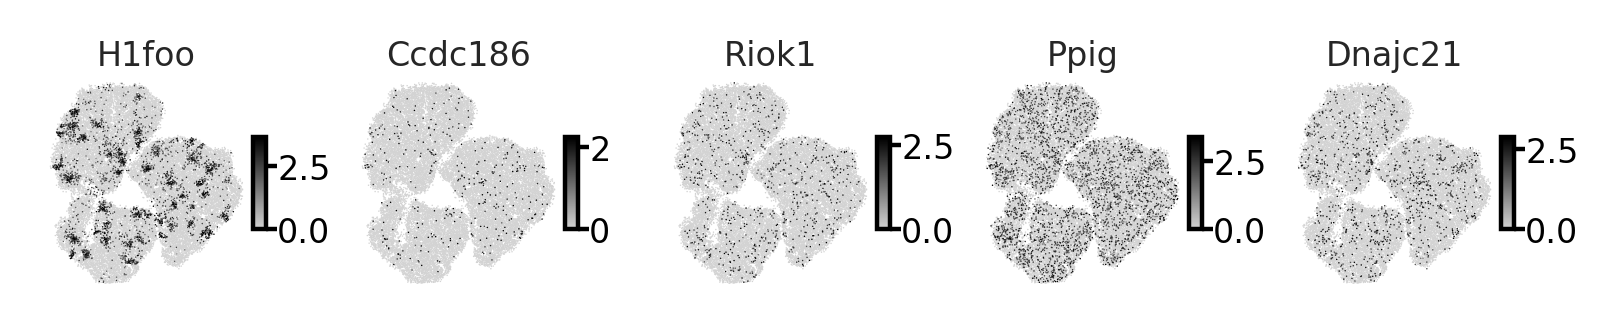

In [578]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(0.7, 0.7), format="pdf")
fig, axs = plt.subplots(1,5, figsize = (5.0,1.0))
gene_list = list(cluster2_markers[1:5]["names"].values)
gene_list.insert(0, "H1foo")
for i, gene in enumerate(gene_list):
    sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "Immature"], color=gene, spot_size=30, frameon=False, wspace=0.1,cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), vmax="p99.2", ax=axs[i], show=False)
    axs[i].set_title(axs[i].get_title(), pad=-10)
for i in range(1,6):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i], 
                 fraction=0.25, aspect=7,
                 pad=0 ,shrink = 0.3)
for i in range(1,6):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
plt.subplots_adjust(wspace=0.0, hspace=0)
plt.show()

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


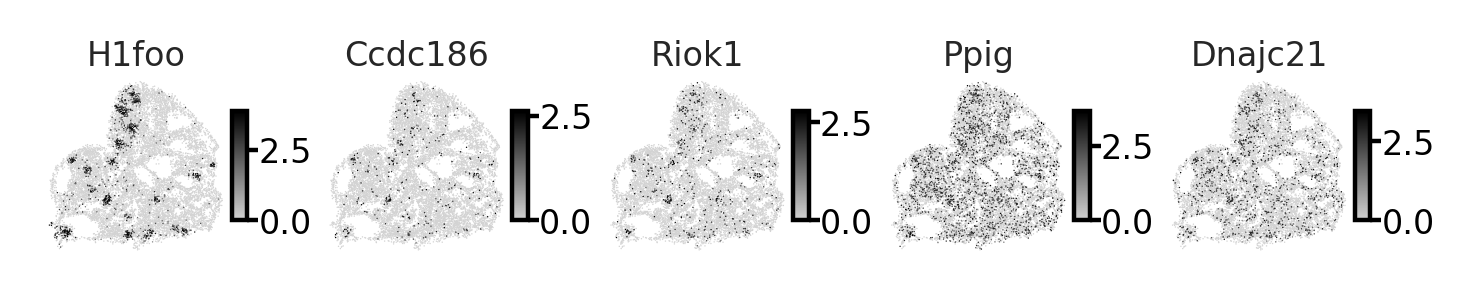

In [584]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(3.0, 3.0), format="pdf")
fig, axs = plt.subplots(1,5, figsize = (4.5,1.2))
gene_list = list(cluster2_markers[1:5]["names"].values)
gene_list.insert(0, "H1foo")
for i, gene in enumerate(gene_list):
    sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "11hr"], color=gene, spot_size=30, frameon=False, wspace=0.1, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), vmax="p99.2", ax=axs[i], show=False)
    axs[i].set_title(axs[i].get_title(), pad=-10)
for i in range(1,6):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i], 
                 fraction=0.25, aspect=7,
                 pad=0 ,shrink = 0.3)
for i in range(1,6):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
plt.subplots_adjust(wspace=0.0, hspace=0)
plt.show()

In [508]:
oocytes_bulk

AnnData object with n_obs × n_vars = 83 × 1421
    obs: 'FollicleNumber', 'Follicle_type', 'Sample', 'size', 'total_counts', 'ngenes_counts', 'S_score', 'G2M_score', 'phase', 'oocyte_leiden_0.5', 'oocyte_leiden_0.7', 'oocyte_leiden_0.8'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Follicle_type_colors', 'log1p', 'hvg', 'pca', 'Sample_colors', 'phase_colors', 'neighbors', 'umap', 'leiden', 'oocyte_leiden_0.7_colors', 'oocyte_leiden_0.8_colors', 'rank_genes_groups_oocytes_Follicle_type', 'rank_genes_groups_oocytes_leiden_0.8', 'dendrogram_oocyte_leiden_0.8', 'dendrogram_Follicle_type'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


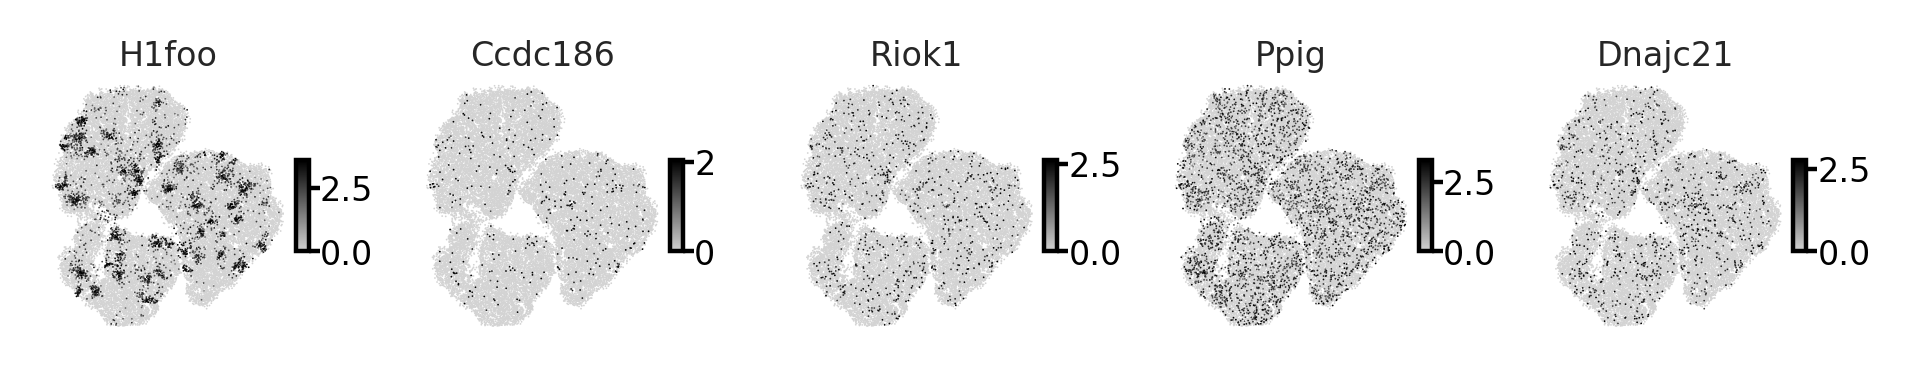

In [590]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(0.8, 0.8), format="pdf")
fig, axs = plt.subplots(1,5, figsize = (6.0,1.0))
gene_list = list(cluster2_markers[1:5]["names"].values)
gene_list.insert(0, "H1foo")
for i, gene in enumerate(gene_list):
    sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "Immature"], color=gene, spot_size=30, frameon=False, wspace=0.1, ncols=5, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), vmax="p99", ax=axs[i], show=False)
    axs[i].set_title(axs[i].get_title(), pad=-10)
for i in range(1,6):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i], 
                 fraction=0.25, aspect=7,
                 pad=0 ,shrink = 0.3)
for i in range(1,6):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
plt.subplots_adjust(wspace=0.0, hspace=0)
plt.savefig("./figures/immature_antral_oocyte_markers.pdf")

/home/mm2937/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


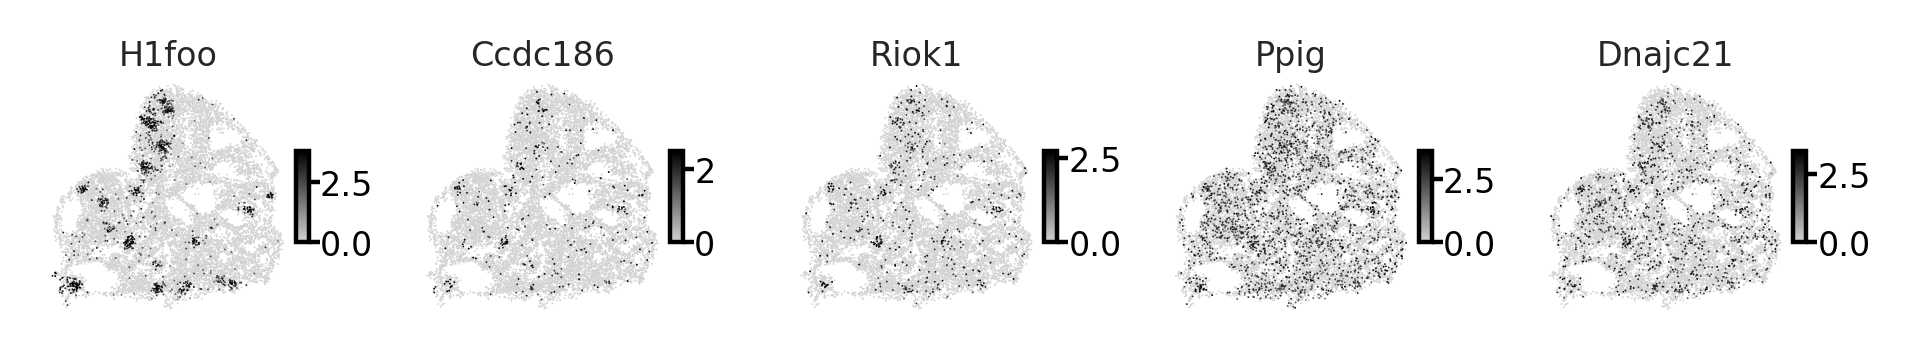

In [591]:
sc.settings.set_figure_params(dpi=200, dpi_save=300, facecolor='white', fontsize=6, frameon=True, figsize=(0.8, 0.8), format="pdf")
fig, axs = plt.subplots(1,5, figsize = (6.0,1.0))
gene_list = list(cluster2_markers[1:5]["names"].values)
gene_list.insert(0, "H1foo")
for i, gene in enumerate(gene_list):
    sc.pl.spatial(adata_ovary_combined[adata_ovary_combined.obs["Sample"] == "11hr"], color=gene, spot_size=30, frameon=False, wspace=0.1, ncols=5, cmap=sns.blend_palette(["lightgrey", sns.xkcd_rgb["black"]], as_cmap=True), vmax="p99", ax=axs[i], show=False)
    axs[i].set_title(axs[i].get_title(), pad=-10)
for i in range(1,6):
    mappable = fig.axes[-i].collections[1]
    colorBar = fig.axes[-i]
    colorBar.remove()
    plt.colorbar(mappable=mappable, ax=axs[-i], 
                 fraction=0.25, aspect=7,
                 pad=0 ,shrink = 0.3)
for i in range(1,6):
    fig.axes[-i].tick_params(length = 2, pad = 0.0)
plt.subplots_adjust(wspace=0.0, hspace=0)
plt.savefig("./figures/11hr_antral_oocyte_markers.pdf")

/home/mm2937/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


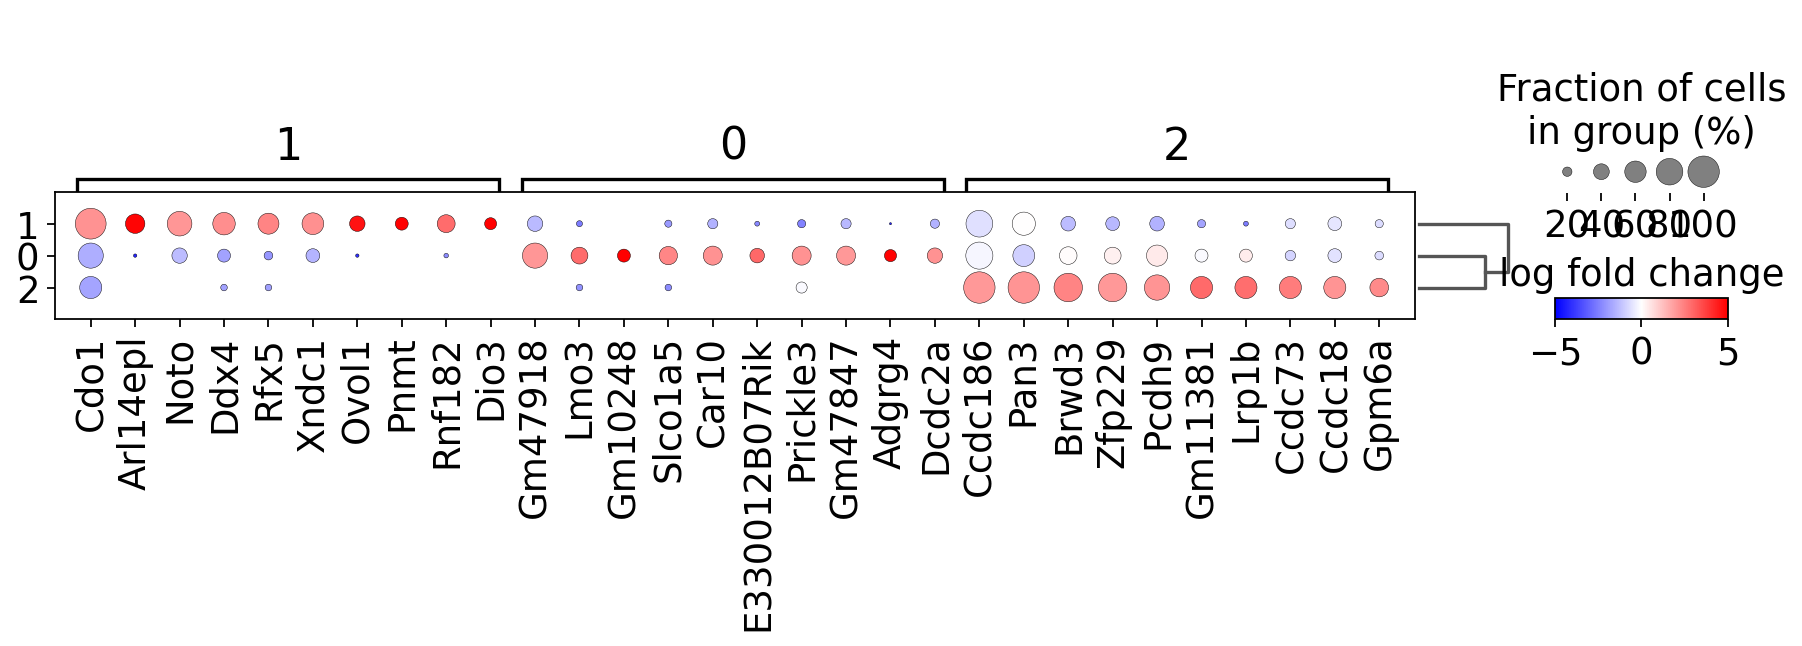

In [502]:
sc.settings.set_figure_params(dpi=80, fontsize=20, facecolor='white', frameon=True, figsize=(10, 5))
sc.pl.rank_genes_groups_dotplot(oocytes_bulk, n_genes=10, key="rank_genes_groups_oocytes_leiden_0.8", values_to_plot='logfoldchanges', min_logfoldchange=2.0, vmax=5, vmin=-5, cmap='bwr')
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(2, 2))
# save = "oocytes_bulk_combined_clusters_markers"

In [511]:
oocytes_bulk.write_h5ad("./../pyobjs/oocytes_bulk_combined_coor_genes.h5ad")

In [1136]:
oocytes_bulk = sc.read_h5ad("./../pyobjs/oocytes_bulk_combined_coor_genes.h5ad")